In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [3]:
import gym
from gym import spaces
import random
from collections import deque, defaultdict

In [4]:
# Load the dataset
file_path1 = "datasets/v2/v2_datasets-corrigido/dataset_normal.csv"
file_path2 = "datasets/v2/v2_datasets-corrigido/dataset_poisoned.csv"

In [5]:
data1 = pd.read_csv(file_path1)
data2 = pd.read_csv(file_path2)

In [6]:
def preprocess_data(df):
    # Convert 'Weapon Detected' to binary (1 for 'Yes', 0 for 'No')
    #df['Weapon Detected'] = df['Weapon Detected'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Encode 'Timestamp' using LabelEncoder
    label_encoder = LabelEncoder()
    df['Hour'] = label_encoder.fit_transform(df['Hour'])
    
    week_label = LabelEncoder()
    df['Weekday/Weekend'] = week_label.fit_transform(df['Weekday/Weekend'])

    # Extract state and action data
    state_data = df[['Hour', 'Presence Detector', 'Face Recognition', 'Weapon Recognition']].values
    actions = df['Action'].values
    
    return state_data, actions

In [7]:
# Preprocess the dataset
state_data_N, actions_N = preprocess_data(data1)

In [8]:
state_data_N

array([[  0,   0,   0,   0],
       [  1,   0,   0,   0],
       [  2,   0,   0,   0],
       ...,
       [141,   1,   4,   0],
       [142,   1,   4,   0],
       [143,   1,   4,   0]])

In [9]:
actions_N

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
# Preprocess the dataset
state_data_P, actions_P = preprocess_data(data2)

In [11]:
state_data_P

array([[  0,   0,   0,   0],
       [  1,   0,   0,   0],
       [  2,   0,   0,   0],
       ...,
       [141,   1,   4,   0],
       [142,   1,   4,   0],
       [143,   1,   4,   0]])

In [12]:
class RealTimeEnvironment(gym.Env):
    def __init__(self, state_data_N, actions_N, state_data_P, actions_P):
        super(RealTimeEnvironment, self).__init__()
        self.state_data_N = state_data_N
        self.actions_data_N = actions_N
        self.state_data_P = state_data_P
        self.actions_data_P = actions_P
        self.current_step = 0

        # Define observation space (4 features: Timestamp, Presence Sensor, Persons Recognized, Weapon Detected)
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        
        # Action space: 2 actions (0: do nothing, 2: inform owner and police)
        self.action_space = spaces.Discrete(2)
        
    def reset_N(self):
        self.current_step = 0
        return self.state_data_N[self.current_step]
    
    def reset_P(self):
        self.current_step = 0
        return self.state_data_P[self.current_step]

    def step_N(self, action):
        correct_action = self.actions_data_N[self.current_step]
        reward = 1 if (action * 2) == correct_action else -1
        
        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.state_data_N)
        
        # Get the next state
        if not done:
            next_state = self.state_data_N[self.current_step]
        else:
            next_state = np.zeros(self.state_data_N.shape[1])
        
        return next_state, reward, done, {}
    
    def step_P(self, action):
        correct_action = self.actions_data_P[self.current_step]
        reward = 1 if (action * 2) == correct_action else -1
        
        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.state_data_P)
        
        # Get the next state
        if not done:
            next_state = self.state_data_P[self.current_step]
        else:
            next_state = np.zeros(self.state_data_P.shape[1])
        
        return next_state, reward, done, {}
    
    def render_N(self):
        print(f"Step: {self.current_step}, State: {self.state_data_N[self.current_step]}")
        
    def render_P(self):
        print(f"Step: {self.current_step}, State: {self.state_data_P[self.current_step]}")

In [13]:
# Q-Learning parameters
learning_rate = 0.1
discount_factor = 0.99
exploration_rate = 1.0
exploration_decay = 0.995
exploration_min = 0.01
total_episodes = 1000  # Number of episodes for training
state_discretizer = (10, 2, 2, 2)  # Tuple representing discrete bins for each state feature

In [14]:
# Initialize the environment
env = RealTimeEnvironment(state_data_N, actions_N, state_data_P, actions_P)

In [15]:
# Initialize Q-table using a defaultdict for easy default values
q_table = defaultdict(lambda: [0, 0])  # Two actions, initialized to zero

In [16]:
q_table

defaultdict(<function __main__.<lambda>()>, {})

In [17]:
# Helper function to discretize continuous states
def discretize_state(state):
    """Convert continuous state into a discrete tuple."""
    return tuple(int(state[i] // (1 / state_discretizer[i])) for i in range(len(state)))

In [18]:
# Metrics for tracking performance
reward_history = deque(maxlen=2016)
action_accuracy = deque(maxlen=2016)

In [19]:
# Continuous Q-learning training loop
avg_reward = []
suc_rate = []
poison = False
for episode in range(total_episodes):
    state = env.reset_N() if poison == False else env.reset_P()
    state = discretize_state(state)
    done = False
    episode_reward = 0

    while not done:
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < exploration_rate:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[state])  # Exploit the best known action
        
        # Take the action in the environment
        next_state, reward, done, _ = env.step_N(action) if poison == False else env.step_P(action)
        next_state = discretize_state(next_state)
        
        # Update Q-value using Q-learning formula
        best_future_q = max(q_table[next_state]) if not done else 0
        q_table[state][action] += learning_rate * (reward + discount_factor * best_future_q - q_table[state][action])
        
        # Update state and metrics
        state = next_state
        episode_reward += reward
        action_accuracy.append(1 if reward == 1 else 0)  # Track if action was correct
        
    # Track episode reward
    reward_history.append(episode_reward)

    # Decay exploration rate
    exploration_rate = max(exploration_min, exploration_rate * exploration_decay)
    
    #if episode >= 20:
    #    poison = True
    
    # Output training progress
    if episode % 10 == 0:
        average_reward = np.mean(reward_history)
        success_rate = np.mean(action_accuracy)
        avg_reward.append(average_reward)
        suc_rate.append(success_rate)
        print(f"Episode {episode}: Avg Reward = {average_reward:.2f}, Success Rate = {success_rate:.2f}")

Episode 0: Avg Reward = -44.00, Success Rate = 0.49
Episode 10: Avg Reward = -34.00, Success Rate = 0.49
Episode 20: Avg Reward = 20.00, Success Rate = 0.53
Episode 30: Avg Reward = 58.52, Success Rate = 0.54
Episode 40: Avg Reward = 100.54, Success Rate = 0.58
Episode 50: Avg Reward = 147.37, Success Rate = 0.61
Episode 60: Avg Reward = 185.21, Success Rate = 0.59
Episode 70: Avg Reward = 220.82, Success Rate = 0.62
Episode 80: Avg Reward = 258.40, Success Rate = 0.63
Episode 90: Avg Reward = 290.84, Success Rate = 0.64
Episode 100: Avg Reward = 326.61, Success Rate = 0.67
Episode 110: Avg Reward = 359.84, Success Rate = 0.67
Episode 120: Avg Reward = 390.48, Success Rate = 0.68
Episode 130: Avg Reward = 423.15, Success Rate = 0.71
Episode 140: Avg Reward = 453.18, Success Rate = 0.73
Episode 150: Avg Reward = 483.31, Success Rate = 0.72
Episode 160: Avg Reward = 511.65, Success Rate = 0.72
Episode 170: Avg Reward = 539.43, Success Rate = 0.76
Episode 180: Avg Reward = 567.14, Success

In [20]:
episodes = [x for x in range(0,1000,10)]
episodes
            

[0,
 10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 400,
 410,
 420,
 430,
 440,
 450,
 460,
 470,
 480,
 490,
 500,
 510,
 520,
 530,
 540,
 550,
 560,
 570,
 580,
 590,
 600,
 610,
 620,
 630,
 640,
 650,
 660,
 670,
 680,
 690,
 700,
 710,
 720,
 730,
 740,
 750,
 760,
 770,
 780,
 790,
 800,
 810,
 820,
 830,
 840,
 850,
 860,
 870,
 880,
 890,
 900,
 910,
 920,
 930,
 940,
 950,
 960,
 970,
 980,
 990]

In [21]:
import matplotlib.pyplot as plt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


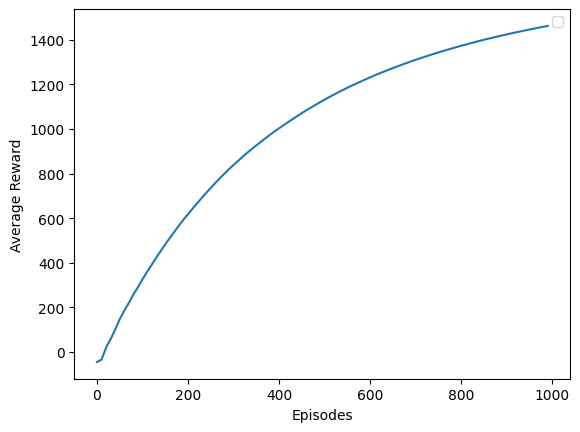

In [24]:
plt.plot(episodes,avg_reward)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.legend()
plt.savefig("Avg_normal.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


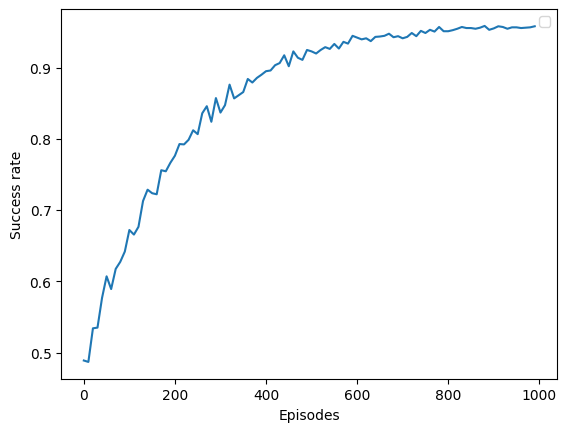

In [25]:
plt.plot(episodes,suc_rate)
plt.xlabel('Episodes')
plt.ylabel('Success rate')
plt.legend()
plt.savefig("suc_normal.png")